## Clustering emails using Gaussian Mixture Models

For this problem, we will be analyzing emails taken from the [Enron Email Dataset](https://www.cs.cmu.edu/~enron/). We have already curated the data for you in the `data/enron` directory, with one file per email. The dataset includes a combination of "spam" and "ham" emails. Spam emails are unsolicited messages intended to sell a product or scam users into providing personal information, while ham emails represent everything that is not spam.

The language used in spam emails tends to be considerably different from typical business emails. Most spam filters leverage this difference in word frequencies to detect spam as it arrives and filter it out of email inboxes. We will use Gaussian Mixture Models (GMMs) to cluster the emails and attempt to identify groups of emails which are likely to be spam.

### Part A: Construct a list of processed documents

Provided below is a function that returns a document present in a file given a filename. The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words. Using the `make_word_list` function, construct a list of processed documents.

In [1]:
import re
import string
import codecs

def make_word_list(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*', '', corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]', '', text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [2]:
import glob
processed_doc = []
path = './data/enron/*.txt'
file_list = glob.glob(path)
for file in file_list:
    text = make_word_list(file)
    processed_doc.append(text)

### Part B: Construct a document matrix 

Next, we construct a document matrix `X` as a matrix of [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) features for each document. TF-IDF features encode information about the word frequency within a document, weighted by the frequency of the same word for corpus as a whole.

   - We use the `TfidfVectorizer` from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to create the document matrix `X`.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the number of unique words in the vocabulary Hint: Look for the `vocabulary_` attribute in the `TfidfVectorizer` object after fitting the vectorizer to the data set. The vocabulary will also be needed in part (d).

In [3]:
########################################################################
######################### Write your code here #########################
########################################################################
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=50,
                             stop_words="english",
                             max_df=0.8)
X = vectorizer.fit_transform(processed_doc)

In [4]:
X.shape

(5171, 1680)

In [5]:
unique_words = vectorizer.vocabulary_
print("Total unique words = ", len(unique_words))

Total unique words =  1680


### Part C: Perform Clustering

Perform clustering on the document matrix `X` using GMMs. 
- Use the `GaussianMixture` module from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) to cluster the documents.
- Set the number of clusters (mixture components) to 3.
- Print the number of documents assigned to each cluster.

In [6]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3, random_state=0)
clusters = gm.fit_predict(X.toarray())
for c_num in range(3):
    total_docs = sum(clusters == c_num)
    print(f"Total doc in cluster {c_num} = ", total_docs)

Total doc in cluster 0 =  4478
Total doc in cluster 1 =  365
Total doc in cluster 2 =  328


### Part D: Characterize the clusters

Now, we will attempt to characterize the clusters based on the frequency of spam-relevant words. 
- We select 3 "spammy" words from the vocabulary that we expect to occur frequently in spam emails and less frequently in normal business emails (e.g., 'click', 'www', 'offer'). Then, construct a list, `spam_indices`, storing the indices of the spammy words we selected in the vocabulary generated by `TfidfVectorizer`.
- We select 3 "hammy" words from the vocabulary we think will occur frequently in business emails and infrequently in spam emails (e.g., 'meeting', 'attached', 'review'). Then, construct a list, `ham_indices`, storing the indices of the hammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- We create a function, `plot_spam_words_by_cluster`, to plot the average TF-IDF features for your selected spammy words and hammy words for each cluster. The function takes the following parameters:
    - `X` is a matrix of TF-IDF features (rows index documents, columns index terms).
    - `predicted` is predicted cluster assignments returned by `GaussianMixture.predict()`
    - `n_clusters` is the number of clusters. This should match the number of clusters from your GMM.
    - `spam_indices` is a list of indices of spammy words in the vocabulary.
    - `ham_indices` is a list of indices of hammy (typical business) words in the vocabulary.

In [7]:
def plot_spam_words_by_cluster(X, predicted, n_clusters, spam_indices, ham_indices):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate mean TF-IDF features for each cluster
    mean_tfidf_spam = []
    mean_tfidf_ham = []
    for spam in spam_indices:
        mean_tfidf_spam.append([])
    for ham in ham_indices:
        mean_tfidf_ham.append([])
    
    for i in range(n_clusters):
        for j, spam_idx in enumerate(spam_indices):
            mean_tfidf_spam[j].append(X[predicted==i, spam_idx].mean())
        for j, ham_idx in enumerate(ham_indices):
            mean_tfidf_ham[j].append(X[predicted==i, ham_idx].mean())
    
    # Generate plot
    fig, ax = plt.subplots()

    ind = np.arange(n_clusters)    # the x locations for the groups
    width = 0.10         # the width of the bars

    # Plot spam bars
    for i, val in enumerate(mean_tfidf_spam):
        spam_bar = ax.bar(ind - (len(mean_tfidf_spam)-i-1)*width, val, width, color='r', bottom=0)

    # Plot ham bars
    for i, val in enumerate(mean_tfidf_ham):
        ham_bar = ax.bar(ind + (len(mean_tfidf_ham)-i)*width, val, width,
                color='y', bottom=0)

    ax.set_title('Mean TF-IDF Features by Cluster for Spam-Relevant Words')
    ax.set_xticks(ind + width / 2)
    xticklabels = []
    for i in range(n_clusters):
        xticklabels.append('Cluster ' + str(i) + '\n(n=' + str((predicted==i).sum()) + ')')
    ax.set_xticklabels(xticklabels)

    ax.legend((spam_bar[0], ham_bar[0]), ('Spammy words', 'Hammy words'))
    ax.autoscale_view()
    ax.set_ylabel('Mean TF-IDF')
    plt.show()

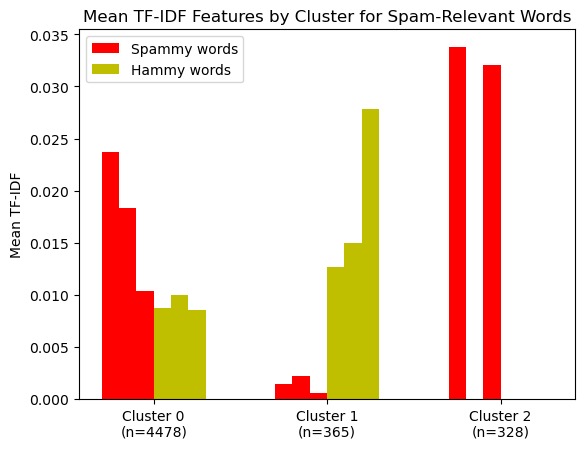

In [8]:
spammy_words = ['click', 'www', 'offer']
hammy_words = ['meeting', 'attached', 'review']
spam_indices = [unique_words[word] for word in spammy_words]
ham_indices = [unique_words[word] for word in hammy_words]
plot_spam_words_by_cluster(X, clusters, 3, spam_indices, ham_indices)

### Part E: Interpret results

From part (d) we can clearly see that cluster 2  contains all the spam emails as indicated by the high frequency of spammy words
Cluster 0 also shows significant number of spam emails, but the mean TF-IDF value are pretty lower as compared to the cluster 2.
It also shows that cluster 1 containes mostly of business emails. This is evident as the mean TF-IDF value of hammy words is much higher.

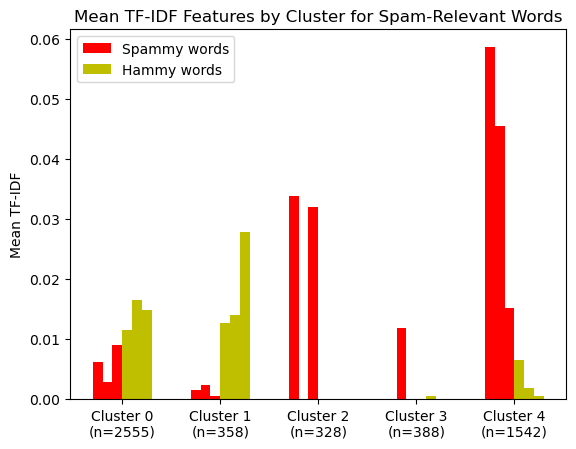

In [9]:
gm = GaussianMixture(n_components=5, random_state=0)
clusters = gm.fit_predict(X.toarray())

spammy_words = ['click', 'www', 'offer']
hammy_words = ['meeting', 'attached', 'review']
spam_indices = [unique_words[word] for word in spammy_words]
ham_indices = [unique_words[word] for word in hammy_words]
plot_spam_words_by_cluster(X, clusters, 5, spam_indices, ham_indices)

When number of cluster is set to 5 we can see that cluster 2, 3 and 4 all have mostly spam emails and now the spam emails in cluster 0 also has reduced. 

## Latent "Purposes" in Mobile Apps 


Think of Android applications as "documents", where "words" are the "permissions" that each app requests. Each app has a set of latent "purposes" (topics); a "purpose" may be a specific task (such as taking photographs and uploading them to the internet), and an application may have a mixture of purposes of varying strength.

Can we uncover these purposes from a dataset of Android applications and the permissions they request?

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Part A: Load the data

The [dataset](http://www.mariofrank.net/andrApps/) contains ~180,000 applications from the Android app store, including each app's name, description and permissions requested. For more about Android app permissions, see [this report](http://www.pewinternet.org/2015/11/10/an-analysis-of-android-app-permissions/).

   * Download the data and unzip it into the same folder as this notebook.
   * Run the cells below to load the data into the notebook.

This may take up ~2GB of RAM.

In [11]:
df = pd.read_csv("android.csv", sep=",",  thousands=",")

In [12]:
df["Number of ratings"] = df["Number of ratings"].astype(int) # fix data type
df = df.drop_duplicates(subset=["App"]).reset_index(drop=True)

In [13]:
df.head(n=3)

,App,Package,Category,Description,Rating,Number of ratings,Price,Related apps,Dangerous permissions count,Safe permissions count,...,Your personal information : read Browser's history and bookmarks (D),Your personal information : read calendar events (D),Your personal information : read contact data (D),Your personal information : read sensitive log data (D),Your personal information : read user defined dictionary (D),Your personal information : retrieve system internal state (S),Your personal information : set alarm in alarm clock (S),Your personal information : write Browser's history and bookmarks (D),Your personal information : write contact data (D),Your personal information : write to user defined dictionary (S)
0,Google Maps,com.google.android.apps.maps,Travel & Local,"Download the latest release of Google Maps, an...",4.4,1438259,$0.00,"{com.jsdfproductions.ctatrackerpro, com.alk.co...",17.0,8,...,0,0,1,0,0,0,0,0,1,0
1,Snowfall Live Wallpaper,fishnoodle.snowfall_free,Personalization,Snowfall Live Wallpaper: Wintertime on your ho...,4.3,18147,$0.00,"{colfore.wallpaper.snowfree, com.tabsoft.wallp...",0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aquarium Live Wallpaper,fishnoodle.aquarium_free,Personalization,A beautiful tropical fish tank live wallpaper!...,4.1,62145,$0.00,"{com.convisual.lwp.fishometerlite, com.accessl...",0.0,0,...,0,0,0,0,0,0,0,0,0,0


### Part B: Convert each app into a "document"

The code below does the following:

   * Filter out all the columns except the permission columns.
   * Convert this dataframe into a numpy matrix.

There are thus 180295 apps (documents) and 173 permissions (words).

   - `X` is the "document" or "word-frequency" matrix.
   - `permission_columns` contains the words ordered by their column index in X.
   - `app_names` contains the application names ordered by their row index in X.
   - `app_ratings` contains the *number* of application ratings (not the ratings themselves).

In [14]:
permission_columns = list(df.columns[10:])
app_names = list(df["App"])
app_ratings = np.array(df["Number of ratings"])
df_perms = df[permission_columns]
X = df_perms.values

### Part C: Downweight "stopwords"

There are some permissions requested by almost all applications (like "INTERNET"), they are similar to stop-words ("the", "and", etc.) in natural language. We can downweight them by TF-IDF normalization.

   * Use the `TfidfTransformer` class in `scikit-learn` to transform X.

In [15]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X)

### Part D: Discover 10 "topics" 

   * We use the `LatentDirichletAllocation` class in `scikit-learn` to fit 10 topics to the data.
   * We use 10 max iterations, set `n_jobs=-1` to use all cores on your machine (if it helps).
   * Feel free to understand and play around with other parameters.
   * This may take around 3 minutes to run.

In [16]:
%%time
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_jobs=-1, n_components = 10, max_iter = 10, random_state = 0)
lda.fit(X_tfidf)

CPU times: user 3.73 s, sys: 363 ms, total: 4.09 s
Wall time: 32.4 s


LatentDirichletAllocation(n_jobs=-1, random_state=0)

In [17]:
lda.components_.shape

(10, 173)

In [18]:
lda.components_.sum(axis=1)

array([35025.54391572, 17415.15453178, 36266.20032237, 12999.00389842,
       24447.86305227, 26184.71915182, 31691.70169978, 21378.55830022,
       27492.14432257, 27476.1769537 ])

Now each app can be viewed as a distribution over these 10 topics, and each topic is a distribution over all the permissions in the data.

### Part E: List the top 10 "words" in each topic

Do any of the topics correspond to meaningful app "purposes"? List the ones you find meaningful below:


In [19]:
topic_word_distributions = np.array([row / row.sum() for row in lda.components_])

In [20]:
topic_word_distributions.shape


(10, 173)

In [21]:
topic_word_distributions.sum(axis=1)


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [23]:
tfidf_transformer.get_feature_names_out()

array(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',
       'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19',
       'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28',
       'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37',
       'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46',
       'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55',
       'x56', 'x57', 'x58', 'x59', 'x60', 'x61', 'x62', 'x63', 'x64',
       'x65', 'x66', 'x67', 'x68', 'x69', 'x70', 'x71', 'x72', 'x73',
       'x74', 'x75', 'x76', 'x77', 'x78', 'x79', 'x80', 'x81', 'x82',
       'x83', 'x84', 'x85', 'x86', 'x87', 'x88', 'x89', 'x90', 'x91',
       'x92', 'x93', 'x94', 'x95', 'x96', 'x97', 'x98', 'x99', 'x100',
       'x101', 'x102', 'x103', 'x104', 'x105', 'x106', 'x107', 'x108',
       'x109', 'x110', 'x111', 'x112', 'x113', 'x114', 'x115', 'x116',
       'x117', 'x118', 'x119', 'x120', 'x121', 'x122', 'x123', 'x124',
       'x125

In [25]:
feature_names = permission_columns
num_top_words = 10

def print_top_words(topic_word_distributions, num_top_words, vectorizer):
    vocab = feature_names
    num_topics = len(topic_word_distributions)
    print(f'Displaying the top', num_top_words,'words per topic and their probability')
    print()
    for topic_idx in range(num_topics):
        print('[Topic ', topic_idx, ']', sep='')            
        sort_indices = np.argsort(-topic_word_distributions[topic_idx])
        for rank in range(num_top_words):
            word_idx = sort_indices[rank]
            print(vocab[word_idx])
        print()
print_top_words(topic_word_distributions, num_top_words, tfidf_transformer)


Displaying the top 10 words per topic and their probability

[Topic 0]
Your location : coarse (network-based) location (D)
Your location : fine (GPS) location (D)
Network communication : full Internet access (D)
Network communication : view network state (S)
Phone calls : read phone state and identity (D)
Storage : modify/delete USB storage contents modify/delete SD card contents (D)
Services that cost you money : directly call phone numbers (D)
Your personal information : read sensitive log data (D)
Network communication : view Wi-Fi state (S)
Default : access checkin properties (S)

[Topic 1]
Hardware controls : control vibrator (S)
Network communication : full Internet access (D)
Network communication : view network state (S)
Storage : modify/delete USB storage contents modify/delete SD card contents (D)
System tools : disable keylock (D)
Phone calls : read phone state and identity (D)
System tools : prevent device from sleeping (D)
Hardware controls : change your audio settings (D)

Topic 2: Account Management and Communication Services
Purpose: Apps focused on account access and management, suggesting a role in communication or financial services, especially those integrating with Google Finance.

Similarly, we can look at other topics:
Topic 4: System Utilities and Boot Operations
Purpose: Apps that start automatically at boot and modify system settings. They could be system optimizers, security apps, or widgets.

Topic 6: Multimedia Content Creation
Purpose: Focused on capturing and recording media (photos, videos, audio), indicating camera apps, voice recorders, or multimedia editing tools.

Topic 8: Call and Application Management
Purpose: Apps that manage phone calls, applications, and network state. They could be call managers, task managers, or security-related apps.

### Part F: For each topic, we list the top 3 apps with at least 100000 ratings having the highest probability assigned to that topic 

   - This further helps us understand what the topics actually mean.
   - However, the data is noisy and this exercise may result in listing a bunch of obscure apps.
   - Hence, filtering out all apps with less than 100000 ratings may help.

In [26]:
n_topics = 3

filtered_apps = [app for app, ratings in zip(app_names, app_ratings) if ratings >= 100000]


top_apps_by_topic = {i: [] for i in range(n_topics)}

topic_probabilities = lda.transform(X_tfidf[df.index[df['App'].isin(filtered_apps)]])


for i in range(n_topics):
    top_app_indices = (-topic_probabilities[:, i]).argsort()[:3]  # Get indices of top apps for the current topic
    top_apps = [filtered_apps[idx] for idx in top_app_indices]  # Get the app names
    top_apps_by_topic[i] = top_apps


for i in range(n_topics):
    print(f"Topic #{i}:")
    for j, app in enumerate(top_apps_by_topic[i]):
        print(f"{j + 1}. {app}")
    print()

Topic #0:
1. Dictionary.com
2. Air Control Lite
3. Paper Toss

Topic #1:
1. Vaulty Free Hides Pictures
2. Live Holdem Poker Pro
3. Bubble Blast 2

Topic #2:
1. Angry Birds Seasons
2. Yoo Ninja! Free
3. Adobe Reader



### Part G: Visualize the document-topic proportion matrix in 2-D using t-SNE

Does our reduced dimensional space contain any structure? Visualize the documents (in the topic-space) using t-SNE.

   * Use `TSNE` from `scikit-learn`.
   * Set the angle to 0.99 and init to 'PCA'. Pick any learning rate that gives you a visually pleasing result.
   * You may `fit` TSNE to a sample of the data (>1000 documents) instead of the full data.
   * Remember to call `fit_transform` to obtain your 2-D data.
   * Plot the t-SNE dimensions as a scatterplot.
   * Color each point based on its most probable topic. Make sure you include a legend (10 colors).
   
Clusters in the t-SNE plot indicate groups of apps that have similar topics.

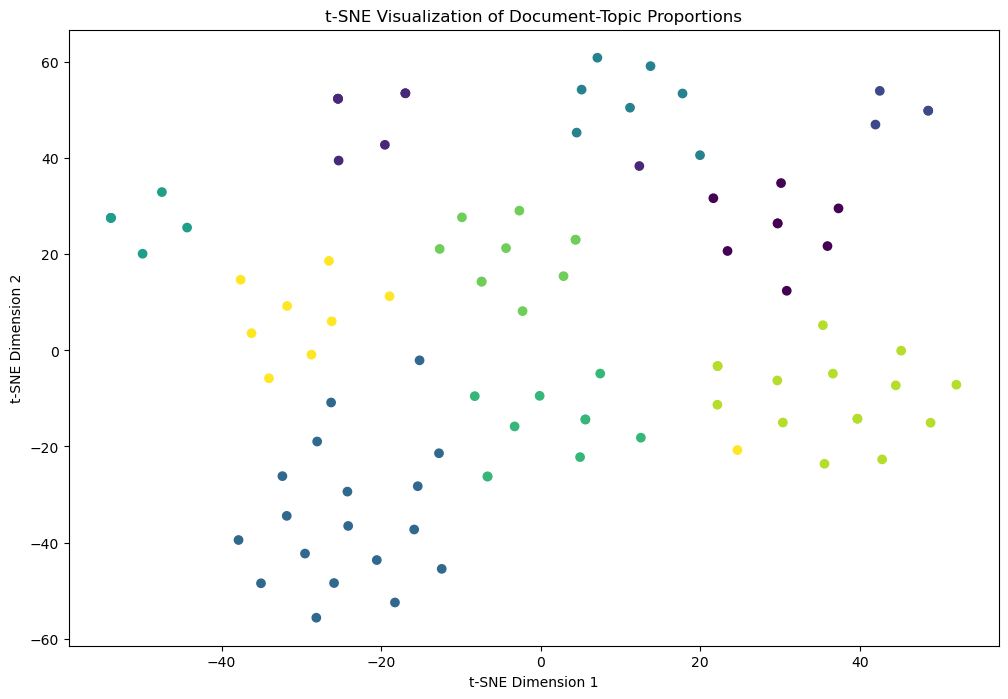

CPU times: user 3.92 s, sys: 2.42 s, total: 6.34 s
Wall time: 1 s


In [32]:
%%time
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
X_embedded = TSNE(angle = 0.99, learning_rate=200, init='pca', n_components = 2, random_state = 0).fit_transform(topic_probabilities[:2000])
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=np.argmax(topic_probabilities[:2000], axis=1))

plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of Document-Topic Proportions")
plt.show()